In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import dateutil.parser
import time
from pandas import DataFrame
import datetime

import os

from scipy.special import gamma

import matplotlib.pyplot as plt
import Visualization

# Evaluación estadístico de salto
---

En este notebook evaluaremos el estadístico de salto definido en Huang & Tauchen [HT] (2005) como:

$$z_{TP, lm, t} = \frac{\log(RV_t) - \log(BV_t)}{\sqrt{(v_{bb}-v_{qq})\frac{1}{M}\max\left\{1, \frac{TP_t}{BV_t^2}\right\}}}$$

# Parámetros del estadístico
---

Siguiendo el paper de HT, asumimos que el log-precio de un activo evoluciona en el tiempo como:

$$dp(t) = \mu(t)dt + \sigma(t)dw(t) + dL_J(t)$$

por lo tanto, se define el retorno geométrico intradía como:

$$r_{t, j} = p_{t-1+\frac{j}{M}} - p_{t-1+\frac{j-1}{M}}$$

De esta manera, podemos evaluar los parámetros necesarios para evaluar el estadístico: la varianza realizada ($RV_t$), *bi-power variation* ($BV_t$) y *tri-power quarticity* ($TP_t$)

## Varianza realizada
---

La varianza realizada se define como:

$$RV_t = \sum_{j=1}^M r_{t, j}^2$$

## Bi-power variation
---

La variación *bi-power* se define como:

$$BV_t = \mu_1^{-2}\left(\frac{M}{M-1}\right)\sum_{j=2}^M|r_{t, j}||r_{t, j-1}|$$

$$BV_t = \frac{\pi}{2}\left(\frac{M}{M-1}\right)\sum_{j=2}^M|r_{t, j}||r_{t, j-1}|$$

## Tri-power quarticity
---

La cuarticidad *tri-power* se define como:

$$TP_t = M \ \mu_{4/3} \left(\frac{M}{M-2}\right)\sum_{j=3}^M|r_{t, j-2}|^{4/3}|\ r_{t, j-1}|^{4/3}\ |r_{t, j}|^{4/3}$$

donde $$\mu_k \equiv \frac{2^{k/2}}{\Gamma(1/2)}\Gamma\left[ \frac{(k+1)}{2} \right]$$

# Cálculo de los parámetros
---

Debido a que tendremos un valor del estadístico por cada día, antes de comenzar el cálculo de los parámetros debemos primero separar nuestros datos para cada día.

In [2]:
# Funcion que retorna una lista con entradas que corresponden a los datos de un dia para una accion

def sep_date(stockdata):
    days = stockdata["dia"].drop_duplicates(keep="first").values
    daily_dfs = []
    for i in days:
        daily_dfs.append(stockdata.loc[stockdata["dia"] == i])
    return daily_dfs

## Cálculo de los retornos
---
El primer paso es calcular los retornos según los supuestos del estadíatico:

$$r_{t, j} = p_{t-1+\frac{j}{M}} - p_{t-1+\frac{j-1}{M}}$$

In [3]:
# Funcion que retorna un 

def get_returns(stockdailydata, lag):
    log_p = np.log(stockdailydata["precio"].copy())
    return log_p.diff(periods=lag).values

In [4]:
testdf = DataFrame({'precio' : [1, 2, 6, 8]})

In [5]:
get_returns(testdf, 1)

array([       nan, 0.69314718, 1.09861229, 0.28768207])

## Cálculo: varianza realizada

La varianza realizada será: $$RV_t = \sum_{j=1}^M r_{t, j}^2$$
donde $$r_{t+j\delta, \delta} = p_{t+j\delta}-p_{t+(j-1)\delta}$$

In [6]:
# Realized volatility

def RV(stockdailydata, lag=1):
    ret = get_returns(stockdailydata, lag)
    return np.nansum(np.square(ret))

In [7]:
# Pequeña evaluacion
RV(testdf)

1.7701629495409348

## Cálculo: bi-power variation

La variación *bi-power* será:

$$BV_t = \frac{\pi}{2}\left(\frac{M}{M-1}\right)\sum_{j=2}^M|r_{t, j}||r_{t, j-1}|$$

In [8]:
# Bi-power variation

def BV(stockdailydata):
    
    # Definimos las constantes
    M    = len(stockdailydata)
    coef = (np.pi/2.)*float(M/(M-1.))
    
    # Calculamos los retornos
    ret1 = get_returns(stockdailydata, lag=1)
    ret2 = get_returns(stockdailydata, lag=2)
    
    sums1 = 0
    
    # Calculamos la sumatoria
    for i in range(2, M):
        #print(ret1[i-1])
        sums1 += np.abs(ret1[i] * ret1[i-1])
        
    '''# Segunda forma - creo que esta mal
    temp_ret = np.array(ret1*ret2)
    temp_sum = np.nansum(temp_ret)'''
    
    return coef*sums1#, coef*temp_sum

In [12]:
BV(testdf)

2.2568176845161334

## Cálculo: tri-power quarticity

Finalmente, el tri-power quarticity es:

$$TP_t = M \ \mu_{4/3} \left(\frac{M}{M-2}\right)\sum_{j=3}^M|r_{t, j-2}|^{4/3}|\ r_{t, j-1}|^{4/3}\ |r_{t, j}|^{4/3}$$

donde $$\mu_k \equiv \frac{2^{k/2}}{\Gamma(1/2)}\Gamma\left[ \frac{(k+1)}{2} \right]$$

In [10]:
# Tri-power quarticity

def TQ(stockdailydata):
    
    # Definimos las constantes
    M    = len(stockdailydata)
    mu43 = np.float_power(2., 2./3.)*gamma(7./6.)/gamma(0.5)
    coef =  mu43*M*(M/(M-2))
    sums = 0
    pp   = 4./3.
    
    # Calculamos los retornos absolutos
    stockdailyret = np.abs(get_returns(stockdailydata, lag=1))
    
    # Calculamos la sumatoria
    for i in range(3, M):
        temp1 = stockdailyret[i]*stockdailyret[i-1]*stockdailyret[i-2]
        temp2 = np.float_power(temp1, pp)
        sums += temp2
    
    return coef*sums

In [11]:
TQ(testdf)

0.8777993836181411

## Cálculo del estadístico de salto
---
Ya habiendo calculado los parámetros del estadístico podemos calcular su valor:

$$z_{TP, lm, t} = \frac{\log(RV_t) - \log(BV_t)}{\sqrt{(v_{bb}-v_{qq})\frac{1}{M}\max\left\{1, \frac{TP_t}{BV_t^2}\right\}}}$$

con $$v_{qq}=2$$ $$v_{bb}=\left(\frac{\pi}{2}\right)^2+\pi-3$$

In [16]:
# Jump statistic

def JS(stockdata):
    
    # Guardamos las fechas para indexar los datos al final
    days = stockdata["dia"].drop_duplicates(keep="first").values
    
    # Inicializamos la lista donde se guardan los resultados
    js_result = []
    
    # Definimos las constantes
    vbb = (np.pi/2)**2 + np.pi - 3.
    vqq = 2.
    
    # Separamos nuestros datos por dias
    stockdailydata = sep_date(stockdata)
    
    # Hacemos el calculo de los valores diarios
    for df in stockdailydata:
        
        # Definimos las constantes DIARIAS
        M = len(df)
        
        # Calculamos los parametros
        rv = RV(df)
        bv = BV(df)
        tp = TQ(df)
        
        # Calculamos el numerador de la operacion
        num = np.log(rv) - np.log(bv)
        
        # Calculamos el denominador de la operacion
        temp = tp/(bv*bv)
        den  = np.sqrt( (vbb-vqq) * 1./M * max(1., temp) )
        
        print("---"*15)
        print("num:", num)
        print("den:", den)
        
        # Guardamos el resultado en proporcion de superacion del valor critico 1.96
        js_result.append((num/den)/1.96)
        
    # Retornamos el resultado
    return DataFrame({"JS_statistic": js_result}, index=days)

In [14]:
# Definimos la direccion del directorio
pathTesis = os.getcwd()
filepath = pathTesis + "/depth_data.csv"

In [15]:
# Importamos los datos
data = pd.read_csv(filepath, parse_dates=["date_time"])

In [17]:
js_test = %time JS(data)

---------------------------------------------
num: 0.26042070561540953
den: 0.0383690321267759
---------------------------------------------
num: 0.5200114604284369
den: 0.029205297794363937
---------------------------------------------
num: 0.3228924617007385
den: 0.060760594852545695
---------------------------------------------
num: 0.5187699217641679
den: 0.020346985837541187
---------------------------------------------
num: 0.5942239312752653
den: 0.04010760527283111
---------------------------------------------
num: 0.2585936932803534
den: 0.036443522227123215
---------------------------------------------
num: 0.524817746254783
den: 0.02919011435598658
---------------------------------------------
num: 0.4195932660229582
den: 0.021487453857763288
---------------------------------------------
num: 0.6215773814207575
den: 0.022265334363274807
---------------------------------------------
num: 0.438382421217252
den: 0.0286361928912245
---------------------------------------------
n

den: 0.02324188233482298
---------------------------------------------
num: 0.9465933586745985
den: 0.03181577149313418
---------------------------------------------
num: 0.6090064221987346
den: 0.019417944464640787
---------------------------------------------
num: 0.42194001564234984
den: 0.020455340187678053
---------------------------------------------
num: 0.3055872329651863
den: 0.014589737908585636
---------------------------------------------
num: -0.23828425340130455
den: 0.14247747157185045
---------------------------------------------
num: 0.3877021403003704
den: 0.022785439665541484
---------------------------------------------
num: 0.5020590303326626
den: 0.02642924121116828
---------------------------------------------
num: 0.29253587026644645
den: 0.028214127014023822
---------------------------------------------
num: 0.3317132124123052
den: 0.04531760709029471
---------------------------------------------
num: 0.4553752124398267
den: 0.02731878245513597
----------------

In [18]:
js_test.head()

,JS_statistic
2017-03-03,3.462889
2017-03-06,9.084378
2017-03-07,2.711314
2017-03-08,13.008243
2017-03-09,7.559052


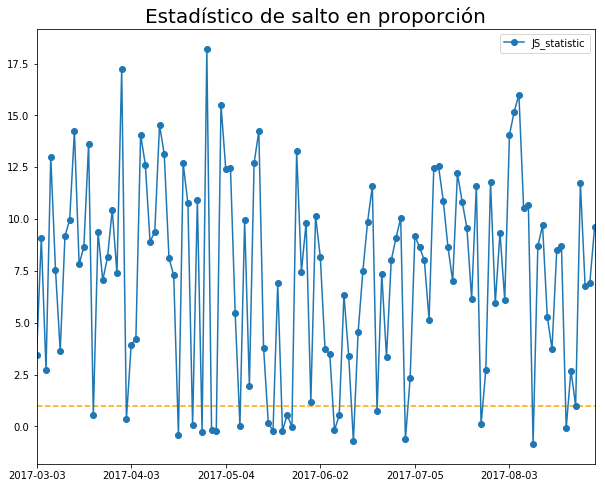

In [19]:
js_test.plot(figsize=(10, 8), marker="o")
plt.title("Estadístico de salto en proporción", fontsize=20)
plt.hlines(y=1, xmin=0, xmax=len(js_test), linestyles="--", color="orange")
plt.show()

# Gráficas
---
Ahora presentamos una visualización de *Realized Volatility*, *Bi-power Variation* y *Tri-power Quarticity*

In [20]:
# Guardamos los dias
dias = data["dia"].drop_duplicates(keep="first").values

# Separamos los datos por dia
datos_diarios = sep_date(data)

realized_volat = []
bipower_var    = []
tripower_quart = []

for df in datos_diarios:
    realized_volat.append(RV(df))
    bipower_var.append(BV(df))
    tripower_quart.append(TQ(df))

realized_volat = DataFrame({"RealizedVariance": realized_volat}, index=dias)
bipower_var    = DataFrame({"BipowerVariation": bipower_var}, index=dias)
tripower_quart = DataFrame({"TripowerQuarticity": tripower_quart}, index=dias)

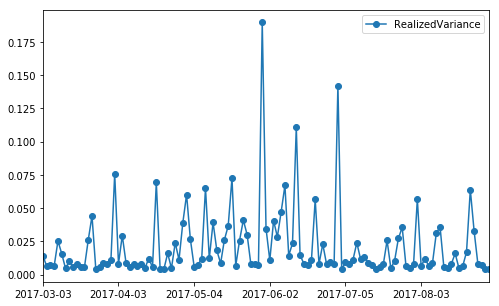

In [21]:
# Grafica RV

realized_volat.plot(figsize=(8, 5), marker="o")
plt.show()

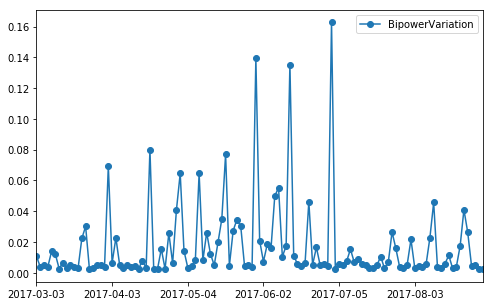

In [22]:
# Grafica BV

bipower_var.plot(figsize=(8, 5), marker="o")
plt.show()

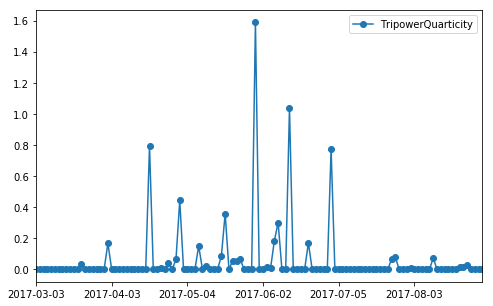

In [23]:
# Grafica TQ

tripower_quart.plot(figsize=(8, 5), marker="o")
plt.show()

In [24]:
tripower_quart.min() # Vemos que el minimo es mayor a cero

TripowerQuarticity    0.000005
dtype: float64